# ***<u>The Future of Basketball Players</u>***

# Set up Environment

In [1]:
# Import modules
import os
import sys
import subprocess
import zipfile
import sklearn
import pandas as pd
import numpy as np
from joblib import dump, load
from pprint import pprint
from pandas_profiling import ProfileReport
from IPython.display import IFrame
import random
from pytictoc import TicToc
from datetime import datetime
from scipy.stats import uniform, randint

In [2]:
# Ensure the directory is correct... every time.
for i in range(5):
    if not os.getcwd().lower() == subprocess.run("git rev-parse --show-toplevel", stdout=subprocess.PIPE).stdout.decode("utf-8").replace("/","\\").strip().lower():
        os.chdir(".."),
    else:
        break

In [3]:
# Set up sys path environment
if not os.path.abspath(".") in sys.path:
    sys.path.append(os.path.abspath("."))
else:
    sys.path.remove(os.path.abspath("."))
    sys.path.append(os.path.abspath("."))

## Custom Globals

In [4]:
### Classes ###

class TicToc(TicToc):
    """Extend the original TicToc class"""
    def toc(self, msg='Elapsed time:', restart=False):
        from timeit import default_timer
        from datetime import timedelta
        self.end     = default_timer()
        self.elapsed = self.end - self.start
        print('%s %s' % (msg, timedelta(seconds=round(self.elapsed))))
        if restart:
            self.start = default_timer()

# Instantiate Global Classes
t = TicToc()

## Get Data

In [5]:
# Check & Create directories
for dir in ["./data/processed/Chris", "./models/Chris"]:
    if not os.path.exists(dir): os.mkdir(dir)

In [6]:
# Use bash to get data from kaggle
!kaggle competitions files -c uts-advdsi-nba-career-prediction
!kaggle competitions download -c uts-advdsi-nba-career-prediction --path ./data/raw --force --quiet

# Unzip the data
with zipfile.ZipFile("./data/raw/uts-advdsi-nba-career-prediction.zip", "r") as z:
    z.extractall("./data/raw")

# Delete the zip file
if os.path.exists("./data/raw/uts-advdsi-nba-career-prediction.zip"):
    os.remove("./data/raw/uts-advdsi-nba-career-prediction.zip")

name                    size  creationDate         
---------------------  -----  -------------------  
sample_submission.csv   40KB  2021-01-30 23:13:35  
train.csv              701KB  2021-01-30 23:13:35  
test.csv               323KB  2021-01-30 23:13:35  


In [7]:
# Turn off table squishing
pd.options.display.max_columns = None

# Import data
data = pd.read_csv("./data/raw/train.csv")

# Check data
# print(data.columns)
display(data)

,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,10556,3799,80,24.3,7.8,3.0,6.4,45.7,0.1,0.3,22.6,2.0,2.9,72.1,2.2,2.0,3.8,3.2,1.1,0.2,1.6,1
1,5342,3800,75,21.8,10.5,4.2,7.9,55.1,-0.3,-1.0,34.9,2.4,3.6,67.8,3.6,3.7,6.6,0.7,0.5,0.6,1.4,1
2,5716,3801,85,19.1,4.5,1.9,4.5,42.8,0.4,1.2,34.3,0.4,0.6,75.7,0.6,1.8,2.4,0.8,0.4,0.2,0.6,1
3,13790,3802,63,19.1,8.2,3.5,6.7,52.5,0.3,0.8,23.7,0.9,1.5,66.9,0.8,2.0,3.0,1.8,0.4,0.1,1.9,1
4,5470,3803,63,17.8,3.7,1.7,3.4,50.8,0.5,1.4,13.7,0.2,0.5,54.0,2.4,2.7,4.9,0.4,0.4,0.6,0.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,2996,11794,32,9.2,1.8,0.7,1.8,40.3,-0.1,-0.2,23.1,0.4,0.6,65.7,0.3,1.8,1.9,0.5,0.3,0.2,0.4,1
7996,11679,11795,54,6.0,1.8,0.7,1.4,48.7,0.1,0.1,3.1,0.2,0.4,70.1,1.0,1.1,2.0,0.1,0.0,0.3,0.3,1
7997,5537,11796,85,28.2,10.7,4.0,9.0,45.1,0.2,0.6,23.6,2.8,3.9,69.7,1.0,2.1,3.1,3.4,1.2,0.2,1.8,1
7998,1292,11797,39,7.7,2.5,1.0,2.3,40.1,-0.3,-0.5,13.3,0.6,0.7,74.3,0.4,0.6,0.9,0.2,0.3,0.3,0.5,1


In [8]:
# Fix column names
print(data.columns)
data.columns = data.columns.str.replace(' ', '_')
print(data.columns)

# Save training data again
data.to_csv("./data/raw/train.csv", index=False)

# Apply same logix to test data
test = pd.read_csv("./data/raw/test.csv")
test.columns = test.columns.str.replace(' ', '_')
test.to_csv("./data/raw/test.csv", index=False)

Index(['Id_old', 'Id', 'GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P Made',
       '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'TARGET_5Yrs'],
      dtype='object')
Index(['Id_old', 'Id', 'GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P_Made',
       '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'TARGET_5Yrs'],
      dtype='object')


## Check Data

In [9]:
# Generate Data Dictionary
# Direct copy & paste from:
# https://www.kaggle.com/c/uts-advdsi-nba-career-prediction/data

DataDict = \
    { "Id_old": "Previous Player Identifier"
    , "Id": "Player Identifier"
    , "GP": "Games Played"
    , "MIN": "Minutes Played"
    , "PTS": "Points Per Game"
    , "FGM": "Field Goals Made"
    , "FGA": "Field Goals Attempts"
    , "FG%": "Field Goals Percent"
    , "3P_Made": "3-Points Made"
    , "3PA": "3-Points Attempts"
    , "3P%": "3-Points Percent"
    , "FTM": "Free Throw Made"
    , "FTA": "Free Throw Attempts"
    , "FT%": "Free Throw Percent"
    , "OREB": "Offensive Rebounds"
    , "DREB": "Defensive Rebounds"
    , "REB": "Rebounds"
    , "AST": "Assists"
    , "STL": "Steals"
    , "BLK": "Blocks"
    , "TOV": "Turnovers"
    , "TARGET_5Yrs": "Outcome: 1 if career length >= 5 years, 0 otherwise"
    }

In [10]:
# View data profile

# Prevent the need to re-run
if os.path.exists("InitialReport.html"):
    IFrame(src="InitialReport.html", width="100%", height=600)
else:
    # Create profile report
    profile = ProfileReport(data, title="Profile Report")
    # Export
    profile.to_file("InitialReport.html")
    # View
    profile

# Fix Data

## Data Manipulation

**Steps:**

1. Drop the `ID` column
1. Pop the `target` column
1. Scale the features
1. Split in to train/test

In [11]:
# Drop ID
data = data.drop(['Id','Id_old'], axis=1)

# Pop targ
feat = data.iloc[:,:-1].to_numpy()
targ = data.iloc[:,-1].to_numpy()

# Scale feat
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
feat = scaler.fit_transform(feat)

# Tran/Test split
# Make sure you stratify the results based on the target variable
from sklearn.model_selection import train_test_split
feat_trn, feat_val, targ_trn, targ_val = train_test_split(feat, targ, stratify=targ, test_size=0.3, random_state=123)

In [12]:
# Dump your objects
dump(data, "./data/processed/Chris/data.joblib")
dump(feat, "./data/processed/Chris/feat.joblib")
dump(targ, "./data/processed/Chris/targ.joblib")
dump(feat_trn, "./data/processed/Chris/feat_trn.joblib")
dump(feat_val, "./data/processed/Chris/feat_val.joblib")
dump(targ_trn, "./data/processed/Chris/targ_trn.joblib")
dump(targ_val, "./data/processed/Chris/targ_val.joblib")
dump(scaler, "./models/Chris/scaler.joblib")

['./models/Chris/scaler.joblib']

## Set up Experiment Space

In [13]:
# Set DF for score dumps
pred_scor = pd.DataFrame(
    { "name": []
    , "when": []
    , "auc": []
    , "sens": []
    , "spec": []
    , "f1": []
    }
)

In [14]:
# Set up re-usable functions

def get_auc(targ:np.real, pred_prob:np.real):
    """
    Get the ROC AUC score from a given probability distribution.

    Args:
        targ (np.real): The true classes.
        pred_prob (np.real): The probability of the true classes. Calculated from using the `Estimator.predict_proba(Y_val)` function.
        
    Raises:
        Assertions: Each parameter will be asserted to the correct type.

    Returns:
        float: The calculated AUC score.
    """

    # Imports
    import numpy as np
    from sklearn.metrics import roc_curve, auc

    # Assertions
    assert np.all(np.isreal(targ))
    assert np.all(np.isreal(pred_prob))

    # Correct
    if len(pred_prob.shape)>1:
        pred_prob = pred_prob[:,1]

    # Compute
    fpr, tpr, thresholds = roc_curve(targ, pred_prob, pos_label=1)
    roc_auc = auc(fpr, tpr)

    # Return
    return roc_auc

def plot_roc_curve(targ:np.real, pred_prob:np.real):
    """
    Plot the ROC curve from a given probability distribution.

    Args:
        targ (np.real): The true scores.
        pred_prob (np.real): The probability of the true scores. Calculated from using the `Estimator.predict_proba(Y_val)` function.

    Returns:
        None: Nothing is returned from this function because the plot is printed.
    """

    # Imports
    import numpy as np
    from sklearn.metrics import roc_curve, auc
    from matplotlib import pyplot as plt

    # Assertions
    assert np.all(np.isreal(targ))
    assert np.all(np.isreal(pred_prob))

    # Generate data
    fpr, tpr, thresholds = roc_curve(targ, pred_prob, pos_label=1)
    roc_auc = auc(fpr, tpr)

    # Generate plot
    plt.figure()
    lw=2
    plt.plot(fpr, tpr, color="darkorange", lw=lw, label="ROC (AUC)={:.3f}".format(roc_auc))
    plt.plot([0,1], [0,1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristics")
    plt.legend(loc="lower right")
    plt.show

    # Return
    return None

def save_reg_perf \
    ( targ:np.real
    , pred:np.real
    , pred_prob:np.real
    , name:str=None
    , df_metrics:pd.DataFrame=None
    , overwrite:bool=True
    , print_all:bool=True
    , print_matrix:bool=True
    , print_plot:bool=True
    , print_dataframe:bool=True
    ):
    """
    Save model metrics to a dataframe.

    Args:
        targ (np.real): The actual values. Can be scalar or arrya, but must be Real numbers.
        pred (np.real): The prediction values. Can be scalar or array, but must be Real numbers. Must provide _either_ `pred` or `pred_probs`. Defaults to None.
        pred_prob (np.real): The prediction probability values. Can be scalar or array, but must be Real numbers. Must provide _either_ `pred` or `pred_probs`. Defaults to None.
        name (str, optional): The name of the data being calculated. If not given, will default to 'None'. Defaults to None.
        df_metrics (pd.DataFrame, optional): The data frame to be updated to contain the data. If not given, will update the `pred_scor` dataframe from the global scope. Defaults to None.
        overwrite (bool, optional): Whether or not to overwrite the data in the dataframe. In SQL-speak: True=UPDATE, False=INSERT. Defaults to True.
        print_all (bool, optional): Wheather or not to turn off all printing. Defaults to True.
        print_matrix (bool, optional): Whether or not to print the confusion matrix. Defaults to True.
        print_plot (bool, optional): Whether or not to print the ROC plot. Defaults to True.
        print_dataframe (bool, optional): Whether or not to print the final updated dataframe. Defaults to True.

    Raises:
        Assertions: Each parameter will be asserted to the proper type and attribute.

    Returns:
        pd.DataFrame: The updated dataframe.
    """    
    
    # Imports
    import numpy as np
    import pandas as pd
    from sklearn.metrics import confusion_matrix as conf
    from sklearn.metrics import roc_auc_score as roc_auc
    from sklearn.metrics import f1_score as f1
    from sklearn.metrics import roc_curve, auc

    # Assertions
    assert np.all(np.isreal(targ))
    assert np.all(np.isreal(pred))
    assert np.all(np.isreal(pred_prob))
    if not name==None:
        assert np.isscalar(name)
        assert isinstance(name, str)
    if not df_metrics==None:
        assert isinstance(df_metrics, pd.DataFrame)
        assert df_metrics.columns == ["name","when","auc","sens","spec","f1"]
    for parameter in [overwrite, print_matrix, print_plot, print_dataframe]:
        assert isinstance(parameter, bool)

    # Ensure we're using the global object here
    global pred_scor

    # If you want to use another dataframe, go right ahead. Else, just keep it simple.
    if df_metrics==None: df = pred_scor
    else: df = df_metrics
    
    # Best to define name, but if blank then make None
    if name==None: name=="None"

    # Fix dimensions of the prob part
    if len(pred_prob.shape)>1:
        pred_prob = pred_prob[:,1]

    # Perform calculations
    val_now = pd.Timestamp.now().strftime('%d/%b %H:%M')
    val_auc = round(roc_auc(targ,pred_prob), 5)
    fpr, tpr, thre = roc_curve(targ, pred_prob, pos_label=1)
    tn, fp, fn, tp = conf(targ,pred).ravel()
    val_sens = round(tp/(tp+fn), 5)
    val_spec = round(tn/(tn+fp), 5)
    val_f1 = round(f1(targ,pred), 5)

    # Two different methods of updating the table. In SQL-Speak this is the difference between INSERT and UPDATE
    if overwrite and name in df["name"].to_numpy():
        df.loc[df["name"] == name, ["when"]] = val_now
        df.loc[df["name"] == name, ["auc"]] = val_auc
        df.loc[df["name"] == name, ["sens"]] = val_sens
        df.loc[df["name"] == name, ["spec"]] = val_spec
        df.loc[df["name"] == name, ["f1"]] = val_f1
    else:
        new = pd.DataFrame \
            (
                { "name": [name]
                , "when": [val_now]
                , "auc": [val_auc]
                , "sens": [val_sens]
                , "spec": [val_spec]
                , "f1": [val_f1]
                }
            )
        df = df.append(new)

    # Fix Pandas indexes
    df.reset_index(drop=True, inplace=True)

    # Assign back to the global scope
    pred_scor = df

    # Print if needed
    if print_all:
        if print_matrix:
            display \
                ( pd.DataFrame \
                    ( conf(targ,pred)
                    , columns=pd.MultiIndex.from_tuples([("pred",0),("pred",1)])
                    , index=pd.MultiIndex.from_tuples([("targ",0),("targ",1)])
                    )
                )
        if print_plot:
            plot_roc_curve(targ, pred_prob)
        if print_dataframe:
            display(df)

    # Return
    return df

# Experimentation

## Attempt 0: Baseline

**Overview**
- Need to get a baseline of the performance.
- Get the `mode()` of the target scores, and apply that over the whole data set.
- We expect an `AUC` score of `0.5`.

pred      
          0     1
targ 0    0  1331
     1    0  6669

,name,when,auc,sens,spec,f1
0,Raw baseline,14/Feb 15:01,0.5,1.0,0.0,0.90926


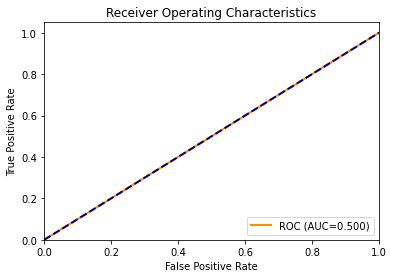

In [15]:
from statistics import mode
from src.utils.misc import get_list_proportions

# Generate actuals
act = np.array(data['TARGET_5Yrs'])
# print("Actual proportions: {}".format(get_list_proportions(act)))

# Generate baseline, based on random re-sampling with the same proportions
# random.seed(123)
# bas = random.choices([1,0], weights=list(get_list_proportions(act)), k=len(data))
bas = np.full(act.shape, mode(act))

# Check objects
# from src.utils.objects import check_object
# check_object(act, "act", _head_size=20)
# check_object(bas, "bas", _head_size=20)

# Check performance
save_reg_perf(act, bas, bas, "Raw baseline", print_matrix=True, print_plot=True, print_dataframe=False)

**Results**
- As expected.
- This is a good start.

## Attempt 1: XGBoost - Default

**Overview**
- Generate and run a stock-standard `XGBClassifier()` model.
- Use only default values.
- Don't do anything fancy.
- Expect to see better performance, but nothing extremely spectacular.

Elapsed time: 0:00:00


pred      
          0     1
targ 0   46   353
     1   72  1929

,name,when,auc,sens,spec,f1
0,Raw baseline,14/Feb 15:01,0.50000,1.00000,0.00000,0.90926
1,01 - XGBoost - Default - within bag,14/Feb 15:01,0.99936,1.00000,0.82940,0.98325
2,01 - XGBoost - Default - out of bag,14/Feb 15:01,0.66738,0.96402,0.11529,0.90077


['./models/Chris/13_XGBoost_Default.joblib']

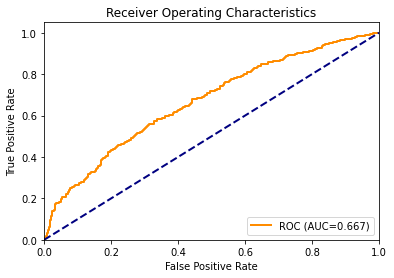

In [16]:
# Import
import xgboost as xgb

# Instantiate
cla = xgb.XGBClassifier \
    ( n_jobs=4
    , random_state=123
    )

# Train
t.tic()
cla.fit(feat_trn, targ_trn, eval_metric="auc")
t.toc()

# Predict
pred_trn = cla.predict(feat_trn)
pred_prob_trn = cla.predict_proba(feat_trn)
pred_val = cla.predict(feat_val)
pred_prob_val = cla.predict_proba(feat_val)

# Check performance
save_reg_perf(targ_trn, pred_trn, pred_prob_trn, "01 - XGBoost - Default - within bag", print_all=False)
save_reg_perf(targ_val, pred_val, pred_prob_val, "01 - XGBoost - Default - out of bag")

# Backup
dump(cla, "./models/Chris/13_XGBoost_Default.joblib")

**Output**:
- Elapsed time: `0:00:00`
- Final AUC: `0.66738`
- Confusion matrix:<br>
```
    |        | pred      |
    |        | 0  | 1    |
    |targ| 0 | 46 | 353  |
    |    | 1 | 72 | 1929 |
```

**Results**
- As expected; it's better.
- Now let's see if we can tune it to get even better again.

## Attempt 2: XGBoost - Random Search

**Overview**
- As re-defining Random Search processes can be teadious, I've defined a re-usable function that will do all the leg-work for me.
- The anticipated outcome is that it will be better than what is modelled above.

In [17]:
# Define reusable function for easy random searching
def easy_random_search \
    ( estimator
    , search_space:dict
    , feat_trn:np.real#=feat_trn
    , targ_trn:np.real#=targ_trn
    , feat_val:np.real#=feat_val
    , targ_val:np.real#=targ_val
    , n_iter:int=100
    , cv:int=5
    , random_state:int=123
    , check_best_params:bool=True
    , dump_model:bool=True
    , dump_location:str="./models/Chris/"
    , dump_name:str=datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    , print_all:bool=True
    , print_matrix:bool=True
    , print_plot:bool=True
    , print_dataframe:bool=True
    ):
    """
    Quickly and easily re-run the Random Search algorithm to find the optimal parameters and see the model results.

    Args:
        estimator (SkLearn_Estimator): An estimator to be used for training. Must be instantiated!
        search_space (dict): The search space to be checked. The keys must be valid hyperparameters in the `estimator` object.
        feat_trn (np.real): The features to be used for training.
        targ_trn (np.real): The target values to be used for training.
        feat_val (np.real): The features to be used for validation.
        targ_val (np.real): The target values to be used for validation.
        n_iter (int, optional): Number of times the Search Space is to be checked. Defaults to 100.
        cv (int, optional): Number of cross-validations to be run per iteration. Defaults to 5.
        random_state (int, optional): The random state to be used for the `cv` splitting. Defaults to 123.
        check_best_params (bool, optional): Whether or not to print the best params from the search space after training. Defaults to True.
        dump_model (bool, optional): Whether or not to dump the model after training. Defaults to True.
        dump_location (str, optional): The location where the model should be dumped to. Defaults to "./models/Chris/".
        dump_name (str, optional): The file name of the model once dumped. Defaults to datetime.now().strftime("%Y-%m-%d %H:%M:%S").
        print_all (bool, optional): Whether or not to print all the results & metrics. Defaults to True.
        print_matrix (bool, optional): Whether or not to print the confusion matrix. Defaults to True.
        print_plot (bool, optional): Whether or not to print the ROC plot. Defaults to True.
        print_dataframe (bool, optional): Whether or not to print the dataframe with the results from all models for all metrics. Defaults to True.

    Raises:
        Assertions: All parameters are asserted to the correct type and correct attributes.
    
    Returns:
        estimator: The re-trained model, using the best params from the search space.
    """

    # Imports
    from sklearn.model_selection import RandomizedSearchCV
    from scipy.stats import uniform, randint
    from src.utils.misc import all_in
    from src.utils.performance import TicToc
    import numpy as np
    from xgboost.sklearn import XGBModel
    from sklearn.metrics import make_scorer
    from sklearn.metrics import roc_auc_score
    from varname import nameof
    import os

    # Instantiate timer
    t = TicToc()

    # Assertions
    # assert "base_estimator" in estimator.__dict__.keys()
    # assert "sklearn" in estimator.__module__.split(".")[0]
    assert isinstance(search_space, dict), \
        "`search_space` must be type `dict`."
    assert all_in(search_space.keys(), estimator.__dict__.keys()), \
        "All keys in `search_space` must be valid parameters in `estimator`."
    for param in ["feat_trn", "targ_trn", "feat_val", "targ_val"]:
        assert isinstance(eval(param), np.ndarray), \
            "`%s` must be type `np.ndarray`." % (param)
        assert np.all(np.isreal(eval(param))), \
            "All elements of `%s` must be Real numbers." % (param)
    assert len(feat_trn)==len(targ_trn), \
        "Lengh of `feat_trn` must be same as `targ_trn`."
    assert len(feat_val)==len(targ_val), \
        "Length of `feat_val` must be same as `targ_val`."
    for param in ["n_iter", "cv", "random_state"]:
        assert isinstance(eval(param), int), \
            "`%s` must be type `int`." % (param)
        assert eval(param)>0, \
            "`%s` must be a positive integer." % (param)
    for param in ["check_best_params", "dump_model", "print_all", "print_matrix", "print_plot", "print_dataframe"]:
        assert isinstance(eval(param), bool), \
            "`%s` must be type `bool`." % (param)
    for param in ["dump_location", "dump_name"]:
        assert isinstance(eval(param), str), \
            "`%s` must be type `str`." % (param)
    assert os.path.isdir(dump_location), \
        "`dump_location` must be a valid direcory."

    # Instantiate trainer
    clf = RandomizedSearchCV \
        ( estimator=estimator
        , param_distributions=search_space
        , n_iter=n_iter
        , scoring={"auc": make_scorer(roc_auc_score, needs_proba=True)}
        , cv=cv
        , refit="auc"
        , random_state=random_state
        , return_train_score=True
        )
    
    # Search for results
    t.tic()
    if isinstance(estimator, XGBModel):
        res = clf.fit(feat_trn, targ_trn, eval_metric="auc")
    else:
        res = clf.fit(feat_trn, targ_trn)
    t.toc()

    # Check best params
    if check_best_params:
        print("Best score: {}".format(res.best_score_))
        print("Best params: {}".format(res.best_params_))
    
    # Update params
    estimator = estimator.set_params(**res.best_params_)

    # Refit
    if isinstance(estimator, XGBModel):
        estimator.fit(feat_trn, targ_trn, eval_metric="auc")
    else:
        estimator.fit(feat_trn, targ_trn)

    # Predict
    pred_trn = estimator.predict(feat_trn)
    pred_prob_trn = estimator.predict_proba(feat_trn)
    pred_val = estimator.predict(feat_val)
    pred_prob_val = estimator.predict_proba(feat_val)

    # Check performance
    save_reg_perf \
        ( targ_trn
        , pred_trn
        , pred_prob_trn
        , dump_name+" - within bag"
        , print_all=False
        , print_matrix=print_matrix
        , print_plot=print_plot
        , print_dataframe=print_dataframe
        )
    save_reg_perf \
        ( targ_val
        , pred_val
        , pred_prob_val
        , dump_name+" - out of bag"
        , print_all=print
        , print_matrix=print_matrix
        , print_plot=print_plot
        , print_dataframe=print_dataframe
        )

    # Backup
    if dump_model:
        dump(estimator, dump_location+dump_name+".joblib")

    # Return
    return estimator

In [18]:
# Define hyperparameters
params = dict \
    ( n_estimators=randint(low=50, high=500)
    , learning_rate=[0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
    , max_depth=randint(low=1, high=200)
    , subsample=uniform(loc=0, scale=1)
    , colsample_bytree=uniform(loc=0, scale=1)
    , gamma=uniform(loc=0, scale=1)
    , reg_alpha=uniform(loc=0, scale=1)
    , reg_lambda=uniform(loc=0, scale=1)
    )

Elapsed time: 0:08:08
Best score: 0.6934866835784483
Best params: {'colsample_bytree': 0.9874783222814236, 'gamma': 0.3494149296248078, 'learning_rate': 0.0001, 'max_depth': 4, 'n_estimators': 149, 'reg_alpha': 0.42834727470094924, 'reg_lambda': 0.2045428595464277, 'subsample': 0.4506364905187348}


pred      
          0     1
targ 0    4   395
     1    4  1997

,name,when,auc,sens,spec,f1
0,Raw baseline,14/Feb 15:01,0.50000,1.00000,0.00000,0.90926
1,01 - XGBoost - Default - within bag,14/Feb 15:01,0.99936,1.00000,0.82940,0.98325
2,01 - XGBoost - Default - out of bag,14/Feb 15:01,0.66738,0.96402,0.11529,0.90077
3,02 - XGBoost - RandomSearch - within bag,14/Feb 15:09,0.74178,0.99979,0.01609,0.91046
4,02 - XGBoost - RandomSearch - out of bag,14/Feb 15:09,0.70406,0.99800,0.01003,0.90917


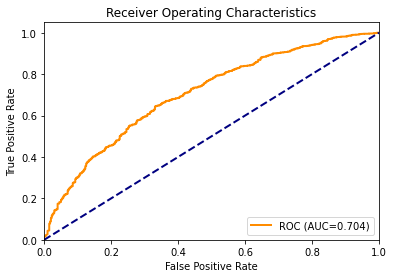

In [19]:
# Imports
from xgboost import XGBClassifier

# Re-Instantiate
cla = XGBClassifier \
    ( n_jobs=4
    , random_state=123
    )
    
# Get baseline of full data set
cla = easy_random_search \
    ( estimator=cla
    , search_space=params
    , feat_trn=feat_trn
    , targ_trn=targ_trn
    , feat_val=feat_val
    , targ_val=targ_val
    , n_iter=100
    , cv=5
    , random_state=123
    , check_best_params=True
    , dump_model=False
    , dump_name="02 - XGBoost - RandomSearch"
    , print_all=True
    , print_dataframe=True
    )

**Output**:
- Elapsed time: `0:08:49`
- Best score: `0.6934866835784483`
- Final AUC: `0.70406`
- Best params: <br>
`{ 'colsample_bytree': 0.9874783222814236`<br>
`, 'gamma': 0.3494149296248078`<br>
`, 'learning_rate': 0.0001`<br>
`, 'max_depth': 4`<br>
`, 'n_estimators': 149`<br>
`, 'reg_alpha': 0.42834727470094924`<br>
`, 'reg_lambda': 0.2045428595464277`<br>
`, 'subsample': 0.4506364905187348`<br>
`}`
- Confusion matrix:<br>
```
    |        | pred     |
    |        | 0 | 1    |
    |targ| 0 | 4 | 395  |
    |    | 1 | 4 | 1997 |
```

**Results:**
- As expected, the AUC is indeed higher.
- It's interesting that the algorithm chose the hyperparameters that it did. Particularly:
    - `max_depth`: I would have thought that it would have gone deeper than only `4` levels?
    - `n_estimators`: Yes, this number seems about right. However, given the small data set, I would have expected it to go a lot higher though.
    - `learning_rate`: This is a fairly typical learning rate; nothing overly remarkable here.
    - `alpha`, `lambda`, `gamma`: The regularisation is slightly on the lower side of `0.5`, but still quite conservative for the `gamma` and `alpha` parameters; though for `lambda` it has gone quite low to `0.2`. As `alpha` represents `l1` regularisation, it is quite interesting that it would have chosen to increase this value to the extent that it did.
- The model doesn't look like it's overfitting; though I'm still not overly satisfied with the results.
- Further experimentation is needed arount the feature selection aspects.

## Attempt 3: XGBoost with Random Search and *Including* Percentages Columns

**Theory**

I have a sneeking suspicion that the model is suffering from the curse of dimensionality. Especially considering that there are only `8,000` lines. So, therefore, I'd like to see which of the columns we should be removing from the bag, and what impact that will have on the overall performance. Effectively, we will be comparing the columns *with* percentages (ie. cols containing `percent` in their description), versus those *without* percentages (ie. cols containing `attempt` and `made` in their description).

Additionally, based off the above Random Search, it is anticipated that by removing those columns with the least level of importance, then this will somehow have a positive effect on the overall result. So, therefore, the 4 columns with the least level of importance (based on both `weight` and `gain` methods) will be removed.

**Overview**
- Firstly, we need to establish which columns to remove.
- Next, we define the indices of the columns which should be used for the subsequent experiments.
- Next, we set the experiment parameters, utilising the same search space as is defined above.
- Next, we run the experiment *only* on the percentages columns.
- The anticipated outcome is that the results from only using the percentages colum will be an improvement overall. When using the raw columns (`made` and `attempt`), then this will have a slight detrimental effect.

In [20]:
# Check which variables are most important
impt = {data.columns[indx]:valu for indx,valu in enumerate(cla.feature_importances_)}
impt = pd.DataFrame({"name":impt.keys(), "valu":impt.values()})
impt["desc"] = impt["name"].map(lambda name: DataDict[name])
impt = impt[["name","desc","valu"]]
display(impt.sort_values("valu", ascending=False))

,name,desc,valu
0,GP,Games Played,0.185843
3,FGM,Field Goals Made,0.085929
2,PTS,Points Per Game,0.078379
9,FTM,Free Throw Made,0.059205
12,OREB,Offensive Rebounds,0.058292
14,REB,Rebounds,0.058196
5,FG%,Field Goals Percent,0.057002
1,MIN,Minutes Played,0.050412
10,FTA,Free Throw Attempts,0.045870
18,TOV,Turnovers,0.044035


In [21]:
# Inspect columns to see which ones to keep
display(impt)

# Define cols to use WITH percentages
# Remove columns with 'Made' and 'Attempt' in the description
# Also remove the 4 lowest performing columns: `FGA`,`AST`,`3P_Made`,`STL`
pcts = [0,1,2,5,8,11,12,13,14,17,18]

# Define cols to use WITHOUT percentages
# Remove columns with 'Percent' in the description
# Also remove the 4 lowest performing columns: `FGA`,`AST`,`3P_Made`,`STL`
non_pcts = [0,1,2,3,7,9,10,12,13,14,17,18]

,name,desc,valu
0,GP,Games Played,0.185843
1,MIN,Minutes Played,0.050412
2,PTS,Points Per Game,0.078379
3,FGM,Field Goals Made,0.085929
4,FGA,Field Goals Attempts,0.027025
5,FG%,Field Goals Percent,0.057002
6,3P_Made,3-Points Made,0.028456
7,3PA,3-Points Attempts,0.035227
8,3P%,3-Points Percent,0.029224
9,FTM,Free Throw Made,0.059205


Elapsed time: 0:06:55
Best score: 0.6956584797727918
Best params: {'colsample_bytree': 0.9874783222814236, 'gamma': 0.3494149296248078, 'learning_rate': 0.0001, 'max_depth': 4, 'n_estimators': 149, 'reg_alpha': 0.42834727470094924, 'reg_lambda': 0.2045428595464277, 'subsample': 0.4506364905187348}


pred      
          0     1
targ 0    3   396
     1    5  1996

,name,when,auc,sens,spec,f1
0,Raw baseline,14/Feb 15:01,0.50000,1.00000,0.00000,0.90926
1,01 - XGBoost - Default - within bag,14/Feb 15:01,0.99936,1.00000,0.82940,0.98325
2,01 - XGBoost - Default - out of bag,14/Feb 15:01,0.66738,0.96402,0.11529,0.90077
3,02 - XGBoost - RandomSearch - within bag,14/Feb 15:09,0.74178,0.99979,0.01609,0.91046
4,02 - XGBoost - RandomSearch - out of bag,14/Feb 15:09,0.70406,0.99800,0.01003,0.90917
5,03 - XGBoost - RandomSearch - WithPercentages ...,14/Feb 15:16,0.73813,0.99914,0.02146,0.91058
6,03 - XGBoost - RandomSearch - WithPercentages ...,14/Feb 15:16,0.70423,0.99750,0.00752,0.90872


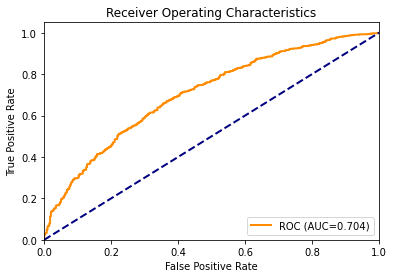

In [22]:
# Re-Instantiate
cla = XGBClassifier \
    ( n_jobs=4
    , random_state=123
    )
    
# Test random search ONLY USING averages
cla = easy_random_search \
    ( estimator=cla
    , search_space=params
    , feat_trn=feat_trn[:,pcts]
    , targ_trn=targ_trn
    , feat_val=feat_val[:,pcts]
    , targ_val=targ_val
    , n_iter=100
    , cv=5
    , random_state=123
    , check_best_params=True
    , dump_model=False
    , dump_name="03 - XGBoost - RandomSearch - WithPercentages"
    , print_all=True
    , print_dataframe=True
    )

**Output:**
- Elapsed time: `0:06:03`
- Best score: `0.6956584797727918`
- Final AUC: `0.70423`
- Best params: <br>
`{ 'colsample_bytree': 0.9874783222814236`<br>
`, 'gamma': 0.3494149296248078`<br>
`, 'learning_rate': 0.0001`<br>
`, 'max_depth': 4`<br>
`, 'n_estimators': 149`<br>
`, 'reg_alpha': 0.42834727470094924`<br>
`, 'reg_lambda': 0.2045428595464277`<br>
`, 'subsample': 0.4506364905187348`<br>
`}`
- Confusion matrix:<br>
```
    |        | pred     |
    |        | 0 | 1    |
    |targ| 0 | 3 | 396  |
    |    | 1 | 5 | 1996 |
```

**Results:**
- There doesn't seem to be an overwhelming improvement here.
- A little bit... But not much. At all.

## Attempt 3: XGBoost with Random Search and *Excluding* Percentages Columns

**Overview:**
- Now to examine the other side of this theory.
- It is anticipated that this will not prove to be any more beneficial that the experiment *including* the percentages column. If anything, it will be performing slightly less than before.

Elapsed time: 0:07:12
Best score: 0.6904615816580166
Best params: {'colsample_bytree': 0.9874783222814236, 'gamma': 0.3494149296248078, 'learning_rate': 0.0001, 'max_depth': 4, 'n_estimators': 149, 'reg_alpha': 0.42834727470094924, 'reg_lambda': 0.2045428595464277, 'subsample': 0.4506364905187348}


pred      
          0     1
targ 0    8   391
     1    3  1998

,name,when,auc,sens,spec,f1
0,Raw baseline,14/Feb 15:01,0.50000,1.00000,0.00000,0.90926
1,01 - XGBoost - Default - within bag,14/Feb 15:01,0.99936,1.00000,0.82940,0.98325
2,01 - XGBoost - Default - out of bag,14/Feb 15:01,0.66738,0.96402,0.11529,0.90077
3,02 - XGBoost - RandomSearch - within bag,14/Feb 15:09,0.74178,0.99979,0.01609,0.91046
4,02 - XGBoost - RandomSearch - out of bag,14/Feb 15:09,0.70406,0.99800,0.01003,0.90917
5,03 - XGBoost - RandomSearch - WithPercentages ...,14/Feb 15:16,0.73813,0.99914,0.02146,0.91058
6,03 - XGBoost - RandomSearch - WithPercentages ...,14/Feb 15:16,0.70423,0.99750,0.00752,0.90872
7,04 - XGBoost - RandomSearch - WithoutPercentag...,14/Feb 15:24,0.72951,0.99893,0.02146,0.91048
8,04 - XGBoost - RandomSearch - WithoutPercentag...,14/Feb 15:24,0.70155,0.99850,0.02005,0.91025


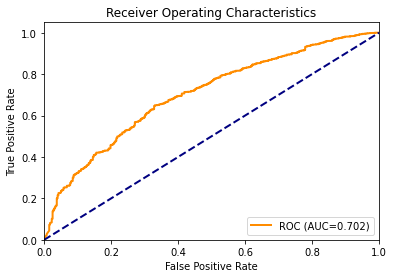

In [23]:
# Re-Instantiate
cla = XGBClassifier \
    ( n_jobs=4
    , random_state=123
    )
    
# Test random search WITHOUT USING averages
cla = easy_random_search \
    ( estimator=cla
    , search_space=params
    , feat_trn=feat_trn[:,non_pcts]
    , targ_trn=targ_trn
    , feat_val=feat_val[:,non_pcts]
    , targ_val=targ_val
    , n_iter=100
    , cv=5
    , random_state=123
    , check_best_params=True
    , dump_model=False
    , dump_name="04 - XGBoost - RandomSearch - WithoutPercentages"
    , print_all=True
    , print_dataframe=True
    )

**Output:**
- Elapsed time: `0:05:48`
- Best score: `0.6904615816580166`
- Final AUC: `0.70155`
- Best params: <br>
`{'colsample_bytree': 0.9874783222814236`<br>
`, 'gamma': 0.3494149296248078`<br>
`, 'learning_rate': 0.0001`<br>
`, 'max_depth': 4`<br>
`, 'n_estimators': 149`<br>
`, 'reg_alpha': 0.42834727470094924`<br>
`, 'reg_lambda': 0.2045428595464277`<br>
`, 'subsample': 0.4506364905187348`<br>
`}`
- Confusion matrix:<br>
```
    |        | pred     |
    |        | 0 | 1    |
    |targ| 0 | 8 | 391  |
    |    | 1 | 3 | 1998 |
```

**Results:**
- As expected, it is slightly less.
- But only by `0.002`... This result is virtually negligible.

## Final Decision

**Overview:**
- It is decided to re-run the model *with* the percentages.
- This one will be dumped and also submitted to Kaggle.

Elapsed time: 0:07:16
Best score: 0.6956584797727918
Best params: {'colsample_bytree': 0.9874783222814236, 'gamma': 0.3494149296248078, 'learning_rate': 0.0001, 'max_depth': 4, 'n_estimators': 149, 'reg_alpha': 0.42834727470094924, 'reg_lambda': 0.2045428595464277, 'subsample': 0.4506364905187348}


pred      
          0     1
targ 0    3   396
     1    5  1996

,name,when,auc,sens,spec,f1
0,Raw baseline,14/Feb 15:01,0.50000,1.00000,0.00000,0.90926
1,01 - XGBoost - Default - within bag,14/Feb 15:01,0.99936,1.00000,0.82940,0.98325
2,01 - XGBoost - Default - out of bag,14/Feb 15:01,0.66738,0.96402,0.11529,0.90077
3,02 - XGBoost - RandomSearch - within bag,14/Feb 15:09,0.74178,0.99979,0.01609,0.91046
4,02 - XGBoost - RandomSearch - out of bag,14/Feb 15:09,0.70406,0.99800,0.01003,0.90917
5,03 - XGBoost - RandomSearch - WithPercentages ...,14/Feb 15:16,0.73813,0.99914,0.02146,0.91058
6,03 - XGBoost - RandomSearch - WithPercentages ...,14/Feb 15:16,0.70423,0.99750,0.00752,0.90872
7,04 - XGBoost - RandomSearch - WithoutPercentag...,14/Feb 15:24,0.72951,0.99893,0.02146,0.91048
8,04 - XGBoost - RandomSearch - WithoutPercentag...,14/Feb 15:24,0.70155,0.99850,0.02005,0.91025
9,03_XGBoost_RandomSearch_FeatureSelection - wit...,14/Feb 15:31,0.73813,0.99914,0.02146,0.91058


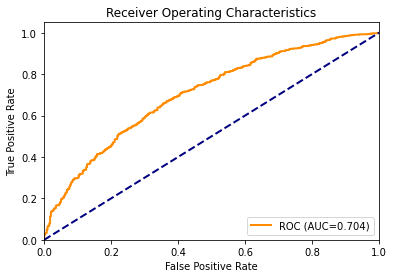

In [24]:
# Choose final model to run again

# Re-Instantiate
cla = XGBClassifier \
    ( n_jobs=4
    , random_state=123
    )
    
# Test random search ONLY USING averages
cla = easy_random_search \
    ( estimator=cla
    , search_space=params
    , feat_trn=feat_trn[:,pcts]
    , targ_trn=targ_trn
    , feat_val=feat_val[:,pcts]
    , targ_val=targ_val
    , n_iter=100
    , cv=5
    , random_state=123
    , check_best_params=True
    , dump_model=True
    , dump_name="03_XGBoost_RandomSearch_FeatureSelection"
    , print_all=True
    , print_dataframe=True
    )

**Output:**
- Elapsed time: `0:06:31`
- Best score: `0.6956584797727918`
- Final AUC: `0.70423`
- Best params: <br>
`{'colsample_bytree': 0.9874783222814236`<br>
`, 'gamma': 0.3494149296248078`<br>
`, 'learning_rate': 0.0001`<br>
`, 'max_depth': 4`<br>
`, 'n_estimators': 149`<br>
`, 'reg_alpha': 0.42834727470094924`<br>
`, 'reg_lambda': 0.2045428595464277`<br>
`, 'subsample': 0.4506364905187348`<br>
`}`
- Confusion matrix:<br>
```
    |        | pred     |
    |        | 0 | 1    |
    |targ| 0 | 3 | 396  |
    |    | 1 | 5 | 1996 |
```

# Examine Model

**Overview**
- Let's take a look at the different parts of the model.
- Mostly interested in the visualisation of the Feature Importances

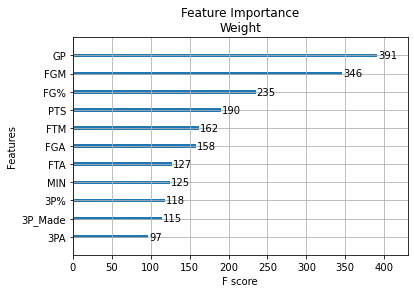

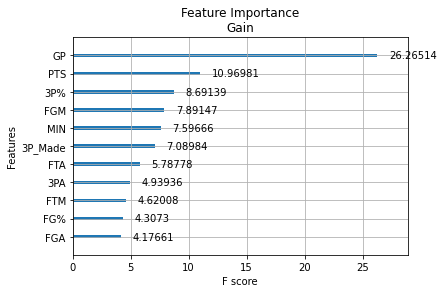

In [25]:
# Define mapper
mapp = {"f{0}".format(i): v for i, v in enumerate(data.columns)}

# Loop different types of importance
for typ in ["weight","gain"]:
    feat_imp = {mapp[k]: round(v,5) for k, v in cla.get_booster().get_score(importance_type=typ).items()}
    xgb.plot_importance(feat_imp, title="Feature Importance\n"+typ.title())

In [26]:
pred_scor

,name,when,auc,sens,spec,f1
0,Raw baseline,14/Feb 15:01,0.50000,1.00000,0.00000,0.90926
1,01 - XGBoost - Default - within bag,14/Feb 15:01,0.99936,1.00000,0.82940,0.98325
2,01 - XGBoost - Default - out of bag,14/Feb 15:01,0.66738,0.96402,0.11529,0.90077
3,02 - XGBoost - RandomSearch - within bag,14/Feb 15:09,0.74178,0.99979,0.01609,0.91046
4,02 - XGBoost - RandomSearch - out of bag,14/Feb 15:09,0.70406,0.99800,0.01003,0.90917
5,03 - XGBoost - RandomSearch - WithPercentages ...,14/Feb 15:16,0.73813,0.99914,0.02146,0.91058
6,03 - XGBoost - RandomSearch - WithPercentages ...,14/Feb 15:16,0.70423,0.99750,0.00752,0.90872
7,04 - XGBoost - RandomSearch - WithoutPercentag...,14/Feb 15:24,0.72951,0.99893,0.02146,0.91048
8,04 - XGBoost - RandomSearch - WithoutPercentag...,14/Feb 15:24,0.70155,0.99850,0.02005,0.91025
9,03_XGBoost_RandomSearch_FeatureSelection - wit...,14/Feb 15:31,0.73813,0.99914,0.02146,0.91058


# Final Processing & Submitting

## Define final processing steps

In [27]:
def final_prediction_processing \
    ( final_model_path:str
    , data_scaler_path:str
    , test_data_path:str="./data/raw/test.csv"
    , test_col_indices=None
    , submission_data_path:str="./data/external/final.csv"
    , check:bool=False
    ):
    """
    Process the data for the final prediction.
    Note, this will update the prediction and save it to the `submission_data_path` location.

    Args:
        final_model_path (str): The location from which the final model should be drawn from. Note, this model should be saved as a `` file type, and once imported, should be a sklearn model class.
        data_scaler_path (str): The location from which the data scaler should be imported from. Note, this should be a sklearn preprocessing class
        test_data_path (str, optional): The location from which the test data should be imported. Note, it should be a `.csv` file type. Defaults to "./data/raw/test.csv".
        submission_data_path (str, optional): The location to which the final submission data should be stored. Note, it should be a `.csv` file type. Defaults to "./data/external/final.csv".
        check (bool, optional): Optional flag for wheather or not to `display()` the final data frame, mainly for checking purposes. Defaults to False.

    Returns:
        pd.DataFrame: The updated `submission_data` dataframe
    """

    # Imports
    import numpy as np
    import pandas as pd
    from src.utils.misc import str_right

    # Assertions
    for parameter in [final_model_path, data_scaler_path, test_data_path, submission_data_path]:
        assert np.isscalar(parameter)
        assert isinstance(parameter, str)
        if parameter in [final_model_path, data_scaler_path]:
            assert str_right(parameter, 7) == ".joblib"
        if parameter in [test_data_path, submission_data_path]:
            assert str_right(parameter, 4) == ".csv"
    assert isinstance(check, bool)
    assert isinstance(test_col_indices, (type(None), list))
    if isinstance(test_col_indices, list):
        assert np.all([isinstance(i, int) for i in test_col_indices])
    
    # Import selected data
    final_model = load(final_model_path)
    data_scaler = load(data_scaler_path)
    test_data = pd.read_csv(test_data_path)

    # Process final data
    submission_data = test_data.pop('Id')
    test_data = test_data.drop(['Id_old'], axis=1)
    test_data = data_scaler.fit_transform(test_data)
    if not test_col_indices is None:
        test_data = test_data[:, test_col_indices]

    # Get prediction
    final_prediction = final_model.predict_proba(test_data)

    # Form final data
    submission_data = pd.concat([pd.DataFrame(submission_data), pd.DataFrame(final_prediction[:,1])], axis=1)
    submission_data.columns = ["Id", "TARGET_5Yrs"]
    # submission_data["TARGET_5Yrs"] = submission_data["TARGET_5Yrs"].apply(lambda pred: 1 if pred > 0.5 else 0)

    # Check
    if check:
        display(submission_data)

    # Save to file
    submission_data.to_csv(submission_data_path, index=False)

    return submission_data

In [28]:
# Process the final data
submission_data = final_prediction_processing \
    ( final_model_path = "./models/Chris/15_XGBoost_RandomSearch_FeatureSelection.joblib"
    , data_scaler_path = "./models/Chris/scaler.joblib"
    , test_data_path = "./data/raw/test.csv"
    , test_col_indices = pcts
    , submission_data_path = "./data/external/final.csv"
    , check = True
    )

,Id,TARGET_5Yrs
0,0,0.504316
1,1,0.504441
2,2,0.506493
3,3,0.506498
4,4,0.504183
...,...,...
3794,3794,0.506547
3795,3795,0.504704
3796,3796,0.503785
3797,3797,0.506516


## Submit to Kaggle

In [29]:
# Function to call Kaggle API
def call_kaggle_api(upload_file, upload_message):
    """
    Call the Kaggle API to submit a file
    Inspiration: https://unix.stackexchange.com/questions/190495/how-to-execute-a-bash-command-in-a-python-script#answer-579917
    
    Args:
        upload_file (str): The source path where the file will be uploaded _from_.
        upload_message (str): The message that will be sent to Kaggle for this submission.

    Raises:
        Exception: CallProcessError, incase subprocess has a wobbly
        Exception: Exception, for everything else

    Returns:
        str: The confirmation string from the API call
    """

    import subprocess

    bash_call = "kaggle competitions submit --competition uts-advdsi-nba-career-prediction --file {upload_file} --message {upload_message} --quiet".format(upload_file=upload_file, upload_message=upload_message)

    try:        
        result = subprocess.run(bash_call, check=True, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    except subprocess.CalledProcessError as err:
        raise Exception(str(err.stderr.decode("utf-8")))
    except Exception as err:
        raise Exception(err)
    else:
        return result.stdout.decode("utf-8")

In [30]:
# Call the API
if False:
    call_kaggle_api \
        ( upload_file = "./data/external/final.csv"
        , upload_message = "CtrlAltElite_XGBoost_RandomSearch_FeatureSelection"
        )